# Feature Importances and Comparison Tables by Metrice Scores

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from impyute.imputation.cs import fast_knn
import pickle

# Scores
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Ensemble models
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier

# Ignoring Errors
import warnings
warnings.simplefilter('ignore')

In [2]:
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
scoring = make_scorer(roc_auc_score)
def gsearch(classifier, X_train, y_train, param_grid, scoring=scoring):
    gs = GridSearchCV(estimator=classifier,
                      param_grid=param_grid, 
                      scoring=scoring,
                      cv=5,
                      n_jobs=-1)
    gs = gs.fit(X_train, y_train)
    return (gs.best_score_, gs.best_params_, gs.best_estimator_)

def collect_scores(classifier, X_train, X_test, y_train, y_test):
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    y_prob = classifier.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_test, y_prob)
    tn, fp, fn, tp = confusion_matrix(y_true=y_test, y_pred=y_pred).ravel()
    
    tpr = tp/(tp + fn)
    tnr = tn/(fp + tn)
    ppv = tp/(tp + fp)
    npv = tn/(tn + fn)
    plr = tpr/(1 - tnr)
    nlr = (1 - tpr)/tnr
    y_test_size = y_test.shape[0]
    fn = fn/y_test_size
    fp = fp/y_test_size
    return [tpr, tnr, fn, fp, ppv, npv, plr, nlr, auc]

In [3]:
def best_estimator(X, y):
    best_lr, best_svm, best_rf = [0, 0], [0, 0], [0, 0]

    pipe_lr = Pipeline([['sc', StandardScaler()], ['clf', LogisticRegression(n_jobs=-1, random_state=1)]])
    pipe_svm = Pipeline([['sc', StandardScaler()], ['clf', SVC(probability=True, random_state=1)]])
    rf = RandomForestClassifier(random_state=1, n_jobs=-1)

    lr_grid = [{'clf__C': param_range,
            'clf__penalty': ['l1','l2']}]

    svm_grid = [{'clf__C': param_range,
                'clf__kernel': ['rbf','sigmoid']}]
    
    rf_grid = [{
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]}]

    kf = StratifiedKFold(10, random_state=1)
    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        lr = gsearch(pipe_lr, X_train, y_train, lr_grid)
        svm = gsearch(pipe_svm, X_train, y_train, svm_grid)
        rf_best = gsearch(rf, X_train, y_train, rf_grid)
        if lr[0] > best_lr[0]:
            best_lr[0] = lr[0]
            best_lr[1] = lr
        if svm[0] > best_svm[0]: 
            best_svm[0] = svm[0]
            best_svm[1] = svm
        if rf_best[0] > best_rf[0]: 
            best_rf[0] = rf_best[0]
            best_rf[1] = rf_best
            
    return (best_lr[1][2], best_svm[1][2], best_rf[1][2], (best_lr[1][1], best_svm[1][1], best_rf[1][1]))

In [4]:
def return_confusion(classifiers, X_train, X_test, y_train, y_test):
    confmats = []
    for classifier in classifiers:
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
        confmats.append(confmat)
    return confmats

In [27]:
def feature_importance_table(columns, X, y, title, save=False):
    feat_labels = columns
    
    forest = RandomForestClassifier(n_estimators=10000,
                                    random_state=0,
                                    n_jobs=-1)
        
    forest.fit(X, y)
    importances = forest.feature_importances_
    
    indices = np.argsort(importances)[::-1]
    srtd_importances = np.round(np.array(importances[indices])[:,np.newaxis],5) #.astype('str')
    srtd_columns = columns[indices]

    plt.figure(figsize=(2,4))
    collabels = ['Feature Importances'] #  ,'F Values', 'P Values'
    table_ = plt.table(cellText=srtd_importances, rowLabels=srtd_columns, colLabels=collabels, loc='center')
    plt.axis('off')
    plt.grid('off')
    plt.suptitle("Feature Importance For \"{}\"".format(title), x=0.0, y=1.05) # x=-0.8, y=1.40
    table_.scale(1,1.1)

#     plt.tight_layout()
    if save:
        plt.savefig(save, dpi=300, bbox_inches="tight")
    plt.show()
    return srtd_columns[:10]

# Importing Data

In [6]:
data = pd.read_excel("NAFLD with FIB4 and NFS Scores.xlsx").drop(294)
features_df = pd.concat([data.iloc[:,1:-13], data[['FIB-4', 'NFS']]], axis=1).drop(columns=["Height", 'Weight'])
targets_df = data[['Significant Fibrosis (No=0, Yes=1) (If Fibrosis 2 and above, there is Significant Fibrosis)',
                         'Advanced Fibrosis (No=0, Yes=1) (If Fibrosis is 3 and above, there is Advanced Fibrosis)']]

In [7]:
# Baseline features (No missed value)
baseline2 = features_df.dropna(axis=1) # shape: (604, 18)

# 25% Missed Value features
missing_data_percentages = features_df.isnull().mean()
threshold_25_df = features_df.iloc[:, missing_data_percentages.values < 0.25]
knn_25 = fast_knn(threshold_25_df.values, k=30) # shape: (604, 35)
threshold_25_df = pd.DataFrame(knn_25, columns=threshold_25_df.columns)

## Feature Importances

In [8]:
with_height_weight_df = pd.concat([baseline2, data[["Height", 'Weight']]], axis=1)

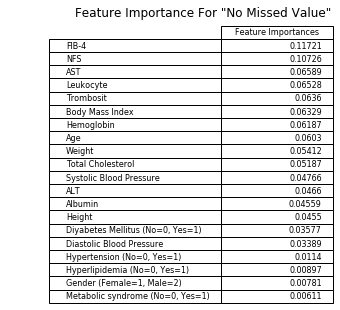

Index(['FIB-4', 'NFS', 'AST', 'Leukocyte', 'Trombosit', 'Body Mass Index',
       'Hemoglobin', 'Age', 'Weight', 'Total Cholesterol'],
      dtype='object')

In [9]:
# with height and weight column
X_train, X_test, y_train, y_test = train_test_split(with_height_weight_df.values, targets_df.iloc[:,1].values,
                                        test_size = 0.2, random_state = 0, stratify=targets_df.iloc[:,1].values)

feature_importance_table(with_height_weight_df.columns, X_train, y_train, title="No Missed Value")

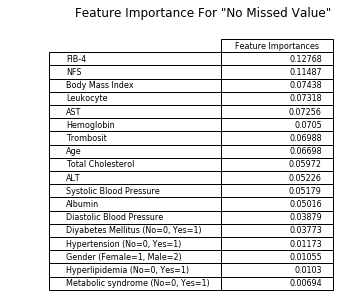

Index(['FIB-4', 'NFS', 'Body Mass Index', 'Leukocyte', 'AST', 'Hemoglobin',
       'Trombosit', 'Age', 'Total Cholesterol', 'ALT'],
      dtype='object')

In [10]:
# After this cell weight and height columns dropped from results
X_train, X_test, y_train, y_test = train_test_split(baseline2.values, targets_df.iloc[:,1].values,
                                        test_size = 0.2, random_state = 0, stratify=targets_df.iloc[:,1].values)

feature_importance_table(baseline2.columns, X_train, y_train, title="No Missed Value")

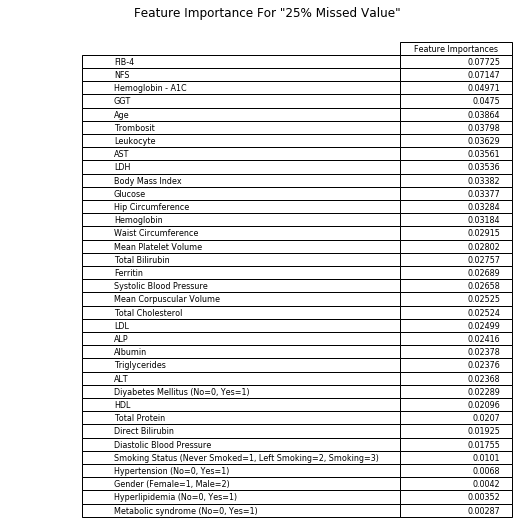

Index(['FIB-4', 'NFS', 'Hemoglobin - A1C', 'GGT', 'Age', 'Trombosit',
       'Leukocyte', 'AST', 'LDH', 'Body Mass Index'],
      dtype='object')

In [28]:
X_train, X_test, y_train, y_test = train_test_split(knn_25, targets_df.iloc[:,1].values,
                                        test_size = 0.2, random_state = 0, stratify=targets_df.iloc[:,1].values)

feature_importance_table(threshold_25_df.columns, X_train, y_train, title="25% Missed Value")

In [12]:
top_baseline_columns = ['FIB-4', 'NFS', 'Body Mass Index', 'Leukocyte', 'AST', 'Hemoglobin',
       'Trombosit', 'Age', 'Total Cholesterol', 'ALT']

top_25_columns = ['FIB-4', 'NFS', 'Hemoglobin - A1C', 'GGT', 'Age', 'Trombosit',
       'Leukocyte', 'AST', 'LDH', 'Body Mass Index']

## Loading Models

In [13]:
# models_4_SF = best_estimator(baseline2.values, targets_df.iloc[:,0].values)
# models_4_AF = best_estimator(baseline2.values, targets_df.iloc[:,1].values)

In [14]:
with open('best_models_with_additional_features2.db', 'rb') as models:
    keeping_models = pickle.load(models)
    
    models_4_SF = keeping_models['0']['SF']
    models_4_AF = keeping_models['0']['AF']

    models_25_SF = keeping_models['25']['SF']
    models_25_AF = keeping_models['25']['AF']

In [15]:
lr_best_sf, svm_best_sf, rf_best_sf = models_4_SF[0], models_4_SF[1], models_4_SF[2]
lr_best_af, svm_best_af, rf_best_af = models_4_AF[0], models_4_AF[1], models_4_AF[2]

lr_best_sf_25, svm_best_sf_25, rf_best_sf_25 = models_25_SF[0], models_25_SF[1], models_25_SF[2]
lr_best_af_25, svm_best_af_25, rf_best_af_25 = models_25_AF[0], models_25_AF[1], models_25_AF[2]

In [16]:
rf_best_af.set_params(max_features = "auto")
rf_best_af_25.set_params(max_features = 'auto')

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=80, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [17]:
bagging = BaggingClassifier(DecisionTreeClassifier(), n_jobs=-1, random_state=1)

sf_models = [lr_best_sf, svm_best_sf, rf_best_sf, bagging]
af_models = [lr_best_af, svm_best_af, rf_best_af, bagging]

sf_25_models = [lr_best_sf_25, svm_best_sf_25, rf_best_sf_25, bagging]
af_25_models = [lr_best_af_25, svm_best_af_25, rf_best_af_25, bagging]

In [20]:
comparison_table = {}
kf = StratifiedKFold(10, random_state=1)
y = targets_df.iloc[:,1].values

for idx in range(10):
    k = idx+1
    X = baseline2[top_baseline_columns[:k]].values
    comparison_table.setdefault(k, [])
    if k == 3:
        rf_best_af.set_params(max_features = 3)
    for mdl in af_models:
        avrg = []
        for train_index, test_index in kf.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            avrg.append(collect_scores(mdl, X_train, X_test, y_train, y_test))
        avrg = pd.DataFrame(np.array(avrg)).replace({np.inf:np.nan}).values
        avrg_list = np.round(np.nanmean(avrg, axis=0, dtype=np.float64),3).tolist()
        avrg_list[0], avrg_list[1] = round(avrg_list[0]*100), round(avrg_list[1]*100)
        avrg_list[2], avrg_list[3] = avrg_list[2], avrg_list[3]
        comparison_table[k].append(avrg_list)

In [21]:
columns = ['Sensitivity (%)', 'Specificity (%)', 'FN', 'FP', 'PPV', 'NPV', 'PLR', 'NLR', 'AUC']
index = ['LR', 'SVM', 'RandomForest', 'Bagging']
tuples = [(f'K{k}', f'{value}') for k in range(1,11) for value in index]
index1 = pd.MultiIndex.from_tuples(tuples)
sf_table_df = pd.DataFrame(np.vstack([np.array(comparison_table[i]) for i in range(1,11)]), index=index1, columns=columns)
sf_table_df

Sensitivity (%)  Specificity (%)     FN     FP    PPV  \
K1  LR                       16.0             99.0  0.151  0.012  0.731   
    SVM                      14.0             99.0  0.154  0.012  0.750   
    RandomForest             29.0             91.0  0.127  0.075  0.417   
    Bagging                  34.0             90.0  0.119  0.084  0.413   
K2  LR                       24.0             96.0  0.136  0.033  0.512   
    SVM                      10.0             99.0  0.161  0.010  0.722   
    RandomForest             30.0             94.0  0.126  0.047  0.519   
    Bagging                  26.0             93.0  0.132  0.055  0.467   
K3  LR                       25.0             95.0  0.134  0.043  0.491   
    SVM                      12.0             97.0  0.157  0.023  0.446   
    RandomForest             26.0             95.0  0.134  0.043  0.500   
    Bagging                  18.0             94.0  0.147  0.047  0.478   
K4  LR                       26.0             94.0  0.132  0.047  0.477   
    SVM                      29.0             94.0  0.127  0.050  0.516   
    RandomForest             30.0             96.0  0.126  0.033  0.588   
    Bagging                  28.0             94.0  0.129  0.047  0.517   
K5  LR                       25.0             94.0  0.134  0.052  0.466   
    SVM                      30.0             92.0  0.126  0.066  0.447   
    RandomForest             31.0             96.0  0.124  0.033  0.591   
    Bagging                  28.0             94.0  0.129  0.047  0.524   
K6  LR                       24.0             94.0  0.136  0.053  0.435   
    SVM                      31.0             90.0  0.123  0.083  0.456   
    RandomForest             28.0             96.0  0.129  0.035  0.497   
    Bagging                  25.0             94.0  0.134  0.050  0.533   
K7  LR                       28.0             91.0  0.129  0.075  0.379   
    SVM                      32.0             87.0  0.123  0.106  0.405   
    RandomForest             24.0             96.0  0.136  0.035  0.561   
    Bagging                  24.0             94.0  0.136  0.051  0.448   
K8  LR                       34.0             90.0  0.119  0.085  0.400   
    SVM                      30.0             86.0  0.124  0.116  0.319   
    RandomForest             24.0             96.0  0.136  0.035  0.550   
    Bagging                  21.0             93.0  0.141  0.056  0.406   
K9  LR                       33.0             90.0  0.121  0.083  0.392   
    SVM                      43.0             86.0  0.102  0.115  0.414   
    RandomForest             23.0             96.0  0.137  0.037  0.535   
    Bagging                  20.0             94.0  0.144  0.046  0.444   
K10 LR                       33.0             90.0  0.121  0.086  0.382   
    SVM                      44.0             85.0  0.101  0.123  0.400   
    RandomForest             18.0             96.0  0.147  0.032  0.422   
    Bagging                  21.0             94.0  0.141  0.050  0.480   

                    NPV    PLR    NLR    AUC  
K1  LR            0.844  6.496  0.854  0.767  
    SVM           0.841  6.960  0.871  0.553  
    RandomForest  0.854  3.992  0.786  0.706  
    Bagging       0.861  3.356  0.740  0.663  
K2  LR            0.854  6.176  0.785  0.779  
    SVM           0.835  5.213  0.908  0.600  
    RandomForest  0.861  7.477  0.745  0.760  
    Bagging       0.853  3.355  0.796  0.732  
K3  LR            0.854  6.098  0.786  0.776  
    SVM           0.836  4.274  0.901  0.631  
    RandomForest  0.854  6.510  0.788  0.759  
    Bagging       0.840  3.197  0.876  0.712  
K4  LR            0.855  5.237  0.779  0.767  
    SVM           0.859  6.557  0.756  0.656  
    RandomForest  0.863  7.518  0.732  0.761  
    Bagging       0.858  5.015  0.765  0.736  
K5  LR            0.852  5.809  0.797  0.776  
    SVM           0.858  4.032  0.764  0.636  
    RandomForest  0.865  7.267  0.719  0.766  
  

## 25% Missed Value Top 10

In [25]:
comparison_table = {}
kf = StratifiedKFold(10, random_state=1)
y = targets_df.iloc[:,1].values

for idx in range(10):
    k = idx+1
    X = threshold_25_df[top_25_columns[:k]].values
    comparison_table.setdefault(k, [])
    if k == 3:
        rf_best_af_25.set_params(max_features = 3)
    for mdl in af_25_models:
        avrg = []
        for train_index, test_index in kf.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            avrg.append(collect_scores(mdl, X_train, X_test, y_train, y_test))
        avrg = pd.DataFrame(np.array(avrg)).replace({np.inf:np.nan}).values
        avrg_list = np.round(np.nanmean(avrg, axis=0, dtype=np.float64),3).tolist()
        avrg_list[0], avrg_list[1] = round(avrg_list[0]*100), round(avrg_list[1]*100)
        avrg_list[2], avrg_list[3] = avrg_list[2], avrg_list[3]
        comparison_table[k].append(avrg_list)

In [26]:
columns = ['Sensitivity (%)', 'Specificity (%)', 'FN', 'FP', 'PPV', 'NPV', 'PLR', 'NLR', 'AUC']
index = ['LR', 'SVM', 'RandomForest', 'Bagging']
tuples = [(f'K{k}', f'{value}') for k in range(1,11) for value in index]
index1 = pd.MultiIndex.from_tuples(tuples)
sf_table_df = pd.DataFrame(np.vstack([np.array(comparison_table[i]) for i in range(1,11)]), index=index1, columns=columns)
sf_table_df

Sensitivity (%)  Specificity (%)     FN     FP    PPV  \
K1  LR                       16.0             99.0  0.151  0.012  0.731   
    SVM                      14.0             98.0  0.154  0.013  0.694   
    RandomForest             26.0             90.0  0.132  0.081  0.377   
    Bagging                  34.0             90.0  0.119  0.084  0.413   
K2  LR                       24.0             96.0  0.136  0.033  0.512   
    SVM                      14.0             99.0  0.154  0.007  0.843   
    RandomForest             31.0             94.0  0.124  0.045  0.528   
    Bagging                  26.0             93.0  0.132  0.055  0.467   
K3  LR                       32.0             95.0  0.122  0.043  0.561   
    SVM                      17.0             97.0  0.149  0.021  0.601   
    RandomForest             29.0             94.0  0.127  0.053  0.489   
    Bagging                  23.0             92.0  0.137  0.065  0.392   
K4  LR                       36.0             95.0  0.116  0.043  0.595   
    SVM                      24.0             96.0  0.137  0.031  0.559   
    RandomForest             25.0             94.0  0.134  0.045  0.545   
    Bagging                  26.0             92.0  0.134  0.065  0.340   
K5  LR                       38.0             93.0  0.111  0.056  0.549   
    SVM                      22.0             96.0  0.139  0.037  0.535   
    RandomForest             28.0             95.0  0.129  0.042  0.628   
    Bagging                  23.0             95.0  0.137  0.043  0.539   
K6  LR                       42.0             92.0  0.104  0.062  0.560   
    SVM                      22.0             95.0  0.139  0.038  0.535   
    RandomForest             24.0             95.0  0.136  0.040  0.562   
    Bagging                  24.0             96.0  0.136  0.037  0.679   
K7  LR                       44.0             92.0  0.101  0.065  0.557   
    SVM                      29.0             93.0  0.127  0.060  0.537   
    RandomForest             26.0             95.0  0.132  0.038  0.561   
    Bagging                  30.0             96.0  0.126  0.035  0.678   
K8  LR                       42.0             91.0  0.104  0.071  0.513   
    SVM                      24.0             93.0  0.135  0.055  0.456   
    RandomForest             27.0             96.0  0.131  0.035  0.636   
    Bagging                  28.0             94.0  0.129  0.050  0.547   
K9  LR                       44.0             92.0  0.101  0.065  0.549   
    SVM                      27.0             92.0  0.130  0.065  0.437   
    RandomForest             25.0             96.0  0.134  0.032  0.602   
    Bagging                  26.0             94.0  0.132  0.047  0.608   
K10 LR                       45.0             91.0  0.099  0.076  0.520   
    SVM                      28.0             92.0  0.129  0.061  0.511   
    RandomForest             24.0             96.0  0.136  0.035  0.582   
    Bagging                  29.0             95.0  0.127  0.043  0.557   

                    NPV    PLR    NLR    AUC  
K1  LR            0.844  6.496  0.854  0.767  
    SVM           0.840  6.558  0.873  0.569  
    RandomForest  0.848  3.534  0.823  0.706  
    Bagging       0.861  3.356  0.740  0.663  
K2  LR            0.854  6.176  0.785  0.779  
    SVM           0.841  6.818  0.868  0.619  
    RandomForest  0.863  7.820  0.733  0.760  
    Bagging       0.853  3.355  0.796  0.732  
K3  LR            0.866  6.532  0.716  0.798  
    SVM           0.844  4.863  0.855  0.650  
    RandomForest  0.859  6.625  0.759  0.748  
    Bagging       0.847  3.421  0.832  0.681  
K4  LR            0.872  8.361  0.678  0.802  
    SVM           0.853  8.777  0.796  0.622  
    RandomForest  0.854  5.671  0.786  0.773  
    Bagging       0.852  3.428  0.806  0.746  
K5  LR            0.875  6.699  0.658  0.796  
    SVM           0.850  6.373  0.811  0.622  
    RandomForest  0.859  6.197  0.756  0.770  
  